# Preprocessing

In [902]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [903]:
data = pd.read_csv('/Users/ninawohlert/Development/markant/markant-masterdata/data/02_intermediate/used-cars_2cities_prep.csv', na_values = 'NaN')

In [904]:
data

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.623600,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.370200,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,NaN,gas,3.572100,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.315200,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,...,0,850,6.745236,1993,25,2.928523,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,$1,los angeles,North LA county,2004 toyota camry,like new,NaN,NaN,gas,11.300000,NaN,...,0,1,0.000000,2004,14,2.424803,0,0,0,0
545,$6800,los angeles,central LA,2012 toyota camry se,excellent,4 cylinders,NaN,gas,8.304974,NaN,...,0,6800,8.824677,2012,6,2.116855,0,0,1,0
546,$2000,los angeles,central LA,2008 TOYOTA CAMRY,NaN,NaN,NaN,gas,12.548112,NaN,...,0,2000,7.600903,2008,10,2.529570,0,0,0,0
547,$2700,los angeles,San Fernando,2002 toyota camry,excellent,4 cylinders,NaN,gas,16.100000,NaN,...,0,2700,7.901007,2002,16,2.778819,0,0,0,0


In [905]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")
data["paintcolor"] = data["paintcolor"].fillna("Missing")
data["size"] = data["size"].fillna("Missing")
data["area"] = data["area"].fillna("Missing")
data["subarea"] = data["subarea"].fillna("Missing")

In [906]:
# drop hybrid models then drop column
data = data.loc[data.Hybrid == 0].drop(
    ["Hybrid"], axis=1
) 

In [907]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [908]:
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]

In [909]:
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [910]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]

In [911]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [912]:
data = data.loc[~(data.transmission == "manual")]

In [913]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [914]:
# drop if truck
data = data.loc[~(data.type == "SUV")]
data = data.loc[~(data.type == "pickup")]
data = data.loc[~(data.type == "wagon")]
#drop pricestr
data = data.drop(["pricestr"], axis=1)
data = data.drop(["lnprice"], axis=1)
data = data.drop(["name"], axis=1)

In [915]:
# check frequency by transmission
freq = data.groupby("size").agg(frequency=("size", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
size,,,
Missing,309,65.053,65.053
compact,21,4.421,69.474
full-size,64,13.474,82.948
mid-size,79,16.632,99.580
sub-compact,2,0.421,100.001


In [916]:
data = data.loc[~(data["size"] == "sub-compact")]

In [917]:
# check frequency by transmission
freq = data.groupby("cylinders").agg(frequency=("cylinders", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
cylinders,,,
4 cylinders,247,52.220,52.220
6 cylinders,56,11.839,64.059
8 cylinders,1,0.211,64.270
Missing,168,35.518,99.788
other,1,0.211,99.999


In [918]:
# drop if truck
data = data.loc[~(data.cylinders == "8 cylinders")]
data = data.loc[~(data.cylinders == "other")]

In [919]:
# check frequency by transmission
freq = data.groupby("paintcolor").agg(frequency=("paintcolor", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq

,frequency,percent,cumulative_percent
paintcolor,,,
Missing,207,43.949,43.949
black,54,11.465,55.414
blue,17,3.609,59.023
brown,8,1.699,60.722
custom,5,1.062,61.784
green,11,2.335,64.119
grey,41,8.705,72.824
red,20,4.246,77.070
silver,58,12.314,89.384


In [920]:
data = data.loc[~(data.paintcolor == "yellow")]

In [921]:
data

,area,subarea,condition,cylinders,drive,fuel,odometer,paintcolor,size,transmission,type,dealer,price,year,age,lnodometer,LE,XLE,SE
3,chicago,chicago city,Missing,Missing,fwd,gas,1.315200,Missing,Missing,automatic,sedan,1,15630,2016,2,0.273989,0,0,0
4,chicago,chicago city,good,6 cylinders,fwd,gas,18.700000,red,full-size,automatic,sedan,0,850,1993,25,2.928523,0,0,0
6,chicago,chicago city,Missing,Missing,Missing,gas,16.824259,Missing,Missing,automatic,Missing,0,1600,1998,20,2.822822,1,0,0
7,chicago,chicago city,Missing,Missing,Missing,gas,16.824259,Missing,Missing,automatic,Missing,0,1500,1998,20,2.822822,0,0,0
8,chicago,chicago city,good,4 cylinders,fwd,gas,20.200000,Missing,Missing,automatic,sedan,0,1650,1999,19,3.005683,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,los angeles,North LA county,excellent,6 cylinders,Missing,gas,27.000000,Missing,Missing,automatic,Missing,0,1500,2001,17,3.295837,0,0,0
545,los angeles,central LA,excellent,4 cylinders,Missing,gas,8.304974,Missing,Missing,automatic,Missing,0,6800,2012,6,2.116855,0,0,1
546,los angeles,central LA,Missing,Missing,Missing,gas,12.548112,Missing,Missing,automatic,Missing,0,2000,2008,10,2.529570,0,0,0
547,los angeles,San Fernando,excellent,4 cylinders,Missing,gas,16.100000,Missing,Missing,automatic,Missing,0,2700,2002,16,2.778819,0,0,0


In [922]:
data.columns

Index(['area', 'subarea', 'condition', 'cylinders', 'drive', 'fuel',
       'odometer', 'paintcolor', 'size', 'transmission', 'type', 'dealer',
       'price', 'year', 'age', 'lnodometer', 'LE', 'XLE', 'SE'],
      dtype='object')

In [923]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = data.select_dtypes(include=numerics)
newdf = newdf.drop(columns=['LE','XLE','SE','dealer','price'])
list_numerical = newdf.columns
list_numerical

Index(['odometer', 'year', 'age', 'lnodometer'], dtype='object')

In [924]:
#creating dummy variables
data_ready = pd.get_dummies(data)

In [925]:
data_ready.columns

Index(['odometer', 'dealer', 'price', 'year', 'age', 'lnodometer', 'LE', 'XLE',
       'SE', 'area_chicago', 'area_los angeles', 'subarea_LA long beach',
       'subarea_LA san gabriel', 'subarea_LA westside-southbay',
       'subarea_Missing', 'subarea_North LA county', 'subarea_San Fernando',
       'subarea_central LA', 'subarea_chicago N', 'subarea_chicago S',
       'subarea_chicago W', 'subarea_chicago city', 'subarea_chicago suburbs',
       'subarea_indiana NW', 'condition_Missing', 'condition_excellent',
       'condition_good', 'condition_like new', 'cylinders_4 cylinders',
       'cylinders_6 cylinders', 'cylinders_Missing', 'drive_4wd',
       'drive_Missing', 'drive_fwd', 'drive_rwd', 'fuel_gas',
       'paintcolor_Missing', 'paintcolor_black', 'paintcolor_blue',
       'paintcolor_brown', 'paintcolor_custom', 'paintcolor_green',
       'paintcolor_grey', 'paintcolor_red', 'paintcolor_silver',
       'paintcolor_white', 'size_Missing', 'size_compact', 'size_full-size',
   

In [926]:
data_ready

,odometer,dealer,price,year,age,lnodometer,LE,XLE,SE,area_chicago,...,paintcolor_white,size_Missing,size_compact,size_full-size,size_mid-size,transmission_automatic,type_Missing,type_convertible,type_coupe,type_sedan
3,1.315200,1,15630,2016,2,0.273989,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,18.700000,0,850,1993,25,2.928523,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
6,16.824259,0,1600,1998,20,2.822822,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
7,16.824259,0,1500,1998,20,2.822822,0,0,0,1,...,0,1,0,0,0,1,1,0,0,0
8,20.200000,0,1650,1999,19,3.005683,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,27.000000,0,1500,2001,17,3.295837,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
545,8.304974,0,6800,2012,6,2.116855,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0
546,12.548112,0,2000,2008,10,2.529570,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
547,16.100000,0,2700,2002,16,2.778819,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [927]:
data_ready.columns = data_ready.columns.str.replace(' ', '')
#y = data_ready["price"].values
#data_ready = data_ready.drop(["price"], axis=1)
data_ready['constant'] = 1
#x_columns = list(data_ready.columns)
y = data_ready["price"].reset_index()
y = y.drop(["index"], axis = 1)
data_ready = data_ready.drop(["price"], axis=1).reset_index()

In [928]:
y

,price
0,15630
1,850
2,1600
3,1500
4,1650
...,...
465,1500
466,6800
467,2000
468,2700


In [929]:
data_ready

,index,odometer,dealer,year,age,lnodometer,LE,XLE,SE,area_chicago,...,size_Missing,size_compact,size_full-size,size_mid-size,transmission_automatic,type_Missing,type_convertible,type_coupe,type_sedan,constant
0,3,1.315200,1,2016,2,0.273989,0,0,0,1,...,1,0,0,0,1,0,0,0,1,1
1,4,18.700000,0,1993,25,2.928523,0,0,0,1,...,0,0,1,0,1,0,0,0,1,1
2,6,16.824259,0,1998,20,2.822822,1,0,0,1,...,1,0,0,0,1,1,0,0,0,1
3,7,16.824259,0,1998,20,2.822822,0,0,0,1,...,1,0,0,0,1,1,0,0,0,1
4,8,20.200000,0,1999,19,3.005683,0,0,0,1,...,1,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,543,27.000000,0,2001,17,3.295837,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1
466,545,8.304974,0,2012,6,2.116855,0,0,1,0,...,1,0,0,0,1,1,0,0,0,1
467,546,12.548112,0,2008,10,2.529570,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1
468,547,16.100000,0,2002,16,2.778819,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1


## Standardizing

In [930]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data_ready[list_numerical]) 
data_ready[list_numerical] = scaler.transform(data_ready[list_numerical])

In [931]:
data_ready

,index,odometer,dealer,year,age,lnodometer,LE,XLE,SE,area_chicago,...,size_Missing,size_compact,size_full-size,size_mid-size,transmission_automatic,type_Missing,type_convertible,type_coupe,type_sedan,constant
0,3,-2.141051,1,1.767636,-1.767636,-3.602902,0,0,0,1,...,1,0,0,0,1,0,0,0,1,1
1,4,1.147061,0,-2.228211,2.228211,0.882362,0,0,0,1,...,0,0,1,0,1,0,0,0,1,1
2,6,0.792289,0,-1.359549,1.359549,0.703762,1,0,0,1,...,1,0,0,0,1,1,0,0,0,1
3,7,0.792289,0,-1.359549,1.359549,0.703762,0,0,0,1,...,1,0,0,0,1,1,0,0,0,1
4,8,1.430767,0,-1.185817,1.185817,1.012735,0,0,0,1,...,1,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,543,2.716900,0,-0.838352,0.838352,1.502997,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1
466,545,-0.819025,0,1.072706,-1.072706,-0.489083,0,0,1,0,...,1,0,0,0,1,1,0,0,0,1
467,546,-0.016490,0,0.377776,-0.377776,0.208266,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1
468,547,0.655305,0,-0.664619,0.664619,0.629413,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1


## K-folding

In [932]:
from sklearn.model_selection import train_test_split
data_ready['constant'] = 1
x_train, x_test, y_train, y_test = train_test_split(data_ready, y, test_size=0.3)

In [933]:
num_splits = 4
kfold = KFold(n_splits=num_splits)
folds = {}
count = 1
kfold.get_n_splits(x_train)
print(kfold)
KFold(n_splits=num_splits, random_state=None, shuffle=True)
for train, test in kfold.split(x_train):
    print("TRAIN:", train, "TEST:", test)
    #X_train, X_test = data_ready[train], data_ready[test]
    #y_train, y_test = y[train], y[test]
    folds['fold_{}'.format(count)] = {}
    folds['fold_{}'.format(count)]['train'] = train.tolist()
    folds['fold_{}'.format(count)]['test'] = test.tolist()
    count += 1
print(len(folds) == num_splits)#assert we have the same number of splits
#dump folds to json
import json
with open('folds.json', 'w') as fp:


KFold(n_splits=4, random_state=None, shuffle=False)
TRAIN: [ 83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 

In [934]:
#load to dict to be used
with open('folds.json') as f:
    kfolds = json.load(f)

In [935]:
for key, val in kfolds.items():
    print(key)
    train = val['train']
    test = val['test']
    print(len(train))

fold_1
246
fold_2
247
fold_3
247
fold_4
247


# Implementation

## Simple OLS

In [936]:
from statsmodels.tools.eval_measures import mse,rmse, meanabs
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse,rmse, meanabs

def get_stats(x_train,y_train,x_test,y_test):
    #x_train = sm.add_constant(x_train)
    p_liste=[]
    model = sm.OLS(y_train, x_train)
    results = model.fit()
    print(results.summary())
    for attributeIndex in range (0, len(x_train.columns)):
        p_liste.append(results.pvalues[attributeIndex])
    predictions = results.predict(x_test)
    r2 = r2_score(y_test,predictions)
    mse = mean_squared_error(y_test,predictions)
    #calculate r-squared

    N=x_test.shape[0]
    p=x_test.shape[1]
    x = (1-r2)
    y = (N-1) / (N-p-1)
    adj_rsquared = (1 - (x * y))

    print("R-squared equals: "+ str(r2))
    print("MSE equals " + str(mse))
    print("adjusted R-squared equals: " + str(adj_rsquared))
    
    return r2, mse, adj_rsquared, p_liste

In [937]:
r2, mse, r2adj, p_liste = get_stats(x_train,y_train,x_test,y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     41.15
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           1.55e-98
Time:                        17:41:25   Log-Likelihood:                -2891.3
No. Observations:                 329   AIC:                             5871.
Df Residuals:                     285   BIC:                             6038.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
index             

## forward stepwise regression

In [938]:
import matplotlib.pylab as plt

In [939]:
from pylab import rcParams
def print_hist(hist_dict,stat):

    lists = hist_dict.items() # return a list of tuples
    #You can sort by values using the following, so the graph would look with increaseing gradient
    # lists = sorted(d.items(), key=lambda kv: kv[1], reverse=True)
    x_, y_ = zip(*lists) # unpack a list of pairs into two tuples
    plt.xlabel('Iteration')
    plt.rcParams["figure.figsize"] = (30,5)
    #rcParams['figure.figsize'] = 10, 5
    plt.ylabel(stat)
    y_val=[]
    y_var=[]
    for val in y_:
        y_val.append(val[0])
        y_var.append(val[1])
    plt.plot(x_, y_val)
    plt.xticks(x_,rotation='vertical')
    for i , var in enumerate(y_var):
        plt.text(x_[i],y_val[i],var)
    plt.show()

### STOPPING CRITERION P-VALUES

In [940]:
from decimal import Decimal, ROUND_HALF_EVEN
#k = KFold(n_splits=4, shuffle=False, random_state=None)
def kfold_stepwise(y, data):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    mse_list=[]
    rsquared_adj = []
    aic_list = []
    bic_list = []
    meanabs_list = []

    # Calculating OLS for each fold

    for key, val in kfolds.items():
        #print(key)
        train_index = val['train']
        test_index = val['test']
        #print(train_index)
        #data_train, data_test = data.iloc[train_index], data.iloc[test_index]
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = sm.OLS(y_train, data_train.astype(float)).fit()
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rsquared_adj += [model.rsquared_adj]
        rmse_list += [rmse(y_train, model.predict())]
        mse_list += [mean_squared_error(y_test,model.predict(data_test))] 
        aic_list += [model.aic]
        bic_list += [model.bic]
        meanabs_list += [meanabs(y_train,model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "mse": mse_list,
        "rsquared_adj": rsquared_adj,
        "aic": aic_list,
        "bic": bic_list,
        "meanabs": meanabs_list
    }

def forward_stepwise_regression_loss(data_ready,y,stat, p_thresh):
    #create dataframe with only constant
    cv_list=[]
    df = data_ready[['constant']].copy()
    i=0
    i=i+1
    #
    #aic = get_mse(df,y)
    cv = kfold_stepwise(y, df)
    cv_list = [cv]
    overview = summarize_cv(cv_list,stat)
    #val = round(overview['Model1']['Average'],2)
    val = overview['Model1']['Average']

    iteration_dict = {'current':val}
    print('Iteration 0 value of null model is ' + str(iteration_dict.get('current')))
    hist_dict ={"Step" + str(0): [iteration_dict.get('current'),"Nullmodel"]}
    curr_model = False
    while curr_model == False:
        for (columnName, columnData) in data_ready.iteritems():
            curr_x = df.copy()
            curr_x[columnName] = columnData.values
            #aic = get_mse(curr_x,y)
            #kfold_stepwise(y, curr_x, k)
            cv = kfold_stepwise(y, curr_x)
            cv_list = [cv]
            overview = summarize_cv(cv_list,stat)
            #val = round(overview['Model1']['Average'],2)
            val = overview['Model1']['Average']
            iteration_dict[columnName] = val
        if stat == "r2" or stat == "rsquared_adj":
            columnToAdd = max(iteration_dict, key=iteration_dict.get)
        if stat == "rmse" or stat == "mse" or stat == "meanabs" or stat == "aic" or stat == "bic":
            columnToAdd = min(iteration_dict, key=iteration_dict.get)
            #check p-values
        print('potential col: ' + columnToAdd)
        pmodel = sm.OLS(y, curr_x)
        presults = pmodel.fit()
        non_significant_var = False
        p_liste = []
        for attributeIndex in range (0, len(curr_x.columns)):
            p_liste.append(presults.pvalues[attributeIndex])
        print(p_liste)
        for v in p_liste:
            #print(Decimal(v).quantize(Decimal('.01'), rounding=ROUND_HALF_EVEN)- Decimal(0.01).quantize(Decimal(p_thresh), rounding=ROUND_HALF_EVEN))
            #if v- p_thresh>0:
            if v > p_thresh:
                non_significant_var = True
                #print(p_liste)
        if columnToAdd == "current":
            curr_model = True
            print('Iteration ' + str(i) + ' current model is the best')
            print(curr_x.columns) 
        else:                                         
            if non_significant_var == True:
                curr_model = True
                print('Iteration ' + str(i) + ' current model is the best')
                print(curr_x.columns)
            else:
                print('Iteration ' + str(i) + ' next column to add is ' + columnToAdd + ' with value ' + str(iteration_dict.get(columnToAdd)))
                hist_dict["Step" + str(i)] =[iteration_dict.get(columnToAdd),columnToAdd]
                df[columnToAdd] = data_ready[columnToAdd].values
                data_ready = data_ready.drop(columnToAdd, axis=1) 
                iteration_dict['current'] = iteration_dict.get(columnToAdd)
                del iteration_dict[columnToAdd]
                i = i+1
    return df,hist_dict

def summarize_cv(cvlist, stat):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0][stat]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

#### strict rule (alpha = 0.05)

Iteration 0 value of null model is 18187149.75596239
potential col: lnodometer
[4.331367866374145e-74]
Iteration 1 next column to add is lnodometer with value 5223383.606339557
potential col: age
[6.722580613026318e-147, 6.834144060286521e-92]
Iteration 2 next column to add is age with value 3133213.517283744
potential col: dealer
[1.0678643962902836e-177, 6.6767001279186005e-40, 1.3255169862357045e-37]
Iteration 3 next column to add is dealer with value 2813335.8536842954
potential col: condition_good
[2.7526494645989215e-158, 1.0208211158581207e-36, 8.301500796358303e-38, 2.867843987998857e-09]
Iteration 4 next column to add is condition_good with value 2792824.5915781925
potential col: paintcolor_custom
[1.8493475527104714e-140, 6.382938925331697e-37, 2.8400229328096497e-38, 1.1514955978483784e-09, 0.09504432338598318]
Iteration 5 current model is the best
Index(['constant', 'lnodometer', 'age', 'dealer', 'condition_good'], dtype='object')


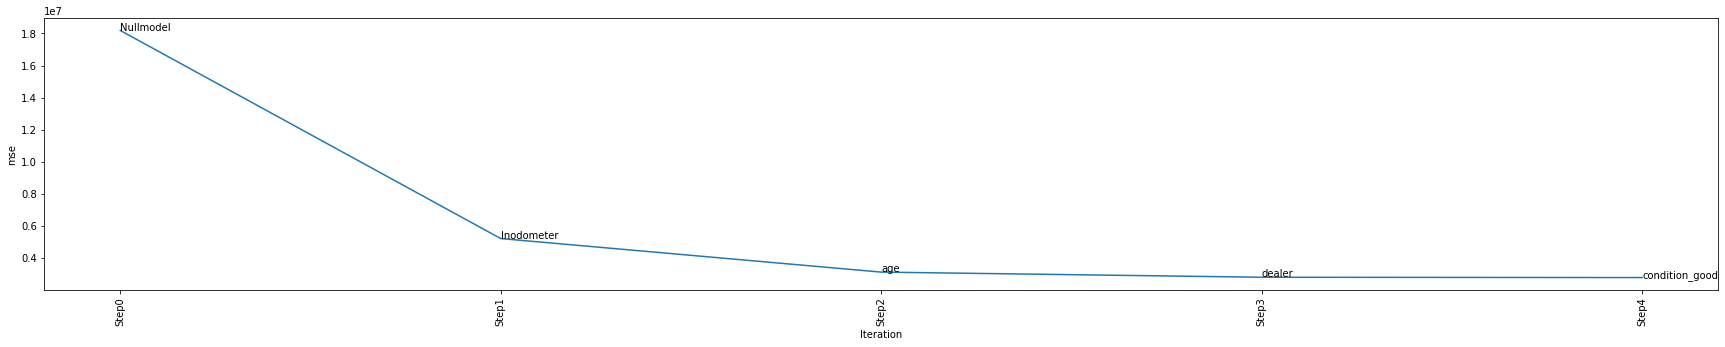

     constant  lnodometer       age  dealer  condition_good
438         1   -2.259757 -1.767636       0               0
406         1    1.004669  0.317154       0               0
252         1    0.723299  1.185817       0               1
3           1    0.703762  1.359549       0               0
132         1   -3.276463 -1.593903       1               0
..        ...         ...       ...     ...             ...
24          1    0.277842  0.317154       0               0
56          1   -0.092823  0.317154       0               0
63          1    0.789500 -0.377776       0               0
62          1    0.701324  0.317154       0               1
416         1   -0.175262 -0.551508       0               1

[329 rows x 5 columns]


In [941]:
curr_x, hist_dict=forward_stepwise_regression_loss(x_train,y_train,"mse",0.05)
print_hist(hist_dict,"mse")
print(curr_x)

In [942]:
#Evaluation:
r2, mse, r2adj, p_liste = get_stats(curr_x,y_train,x_test[curr_x.columns],y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     454.0
Date:                Wed, 23 Feb 2022   Prob (F-statistic):          2.13e-131
Time:                        17:41:32   Log-Likelihood:                -2905.7
No. Observations:                 329   AIC:                             5821.
Df Residuals:                     324   BIC:                             5840.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
constant        5405.7596    121.086     44.

#### aic rule (alpha = 0.157)

Iteration 0 value of null model is 18187149.75596239
potential col: lnodometer
[4.331367866374145e-74]
Iteration 1 next column to add is lnodometer with value 5223383.606339557
potential col: age
[6.722580613026318e-147, 6.834144060286521e-92]
Iteration 2 next column to add is age with value 3133213.517283744
potential col: dealer
[1.0678643962902836e-177, 6.6767001279186005e-40, 1.3255169862357045e-37]
Iteration 3 next column to add is dealer with value 2813335.8536842954
potential col: condition_good
[2.7526494645989215e-158, 1.0208211158581207e-36, 8.301500796358303e-38, 2.867843987998857e-09]
Iteration 4 next column to add is condition_good with value 2792824.5915781925
potential col: paintcolor_custom
[1.8493475527104714e-140, 6.382938925331697e-37, 2.8400229328096497e-38, 1.1514955978483784e-09, 0.09504432338598318]
Iteration 5 next column to add is paintcolor_custom with value 2780524.837079458
potential col: subarea_centralLA
[2.0864440028065602e-140, 3.4534255697439782e-37, 1.

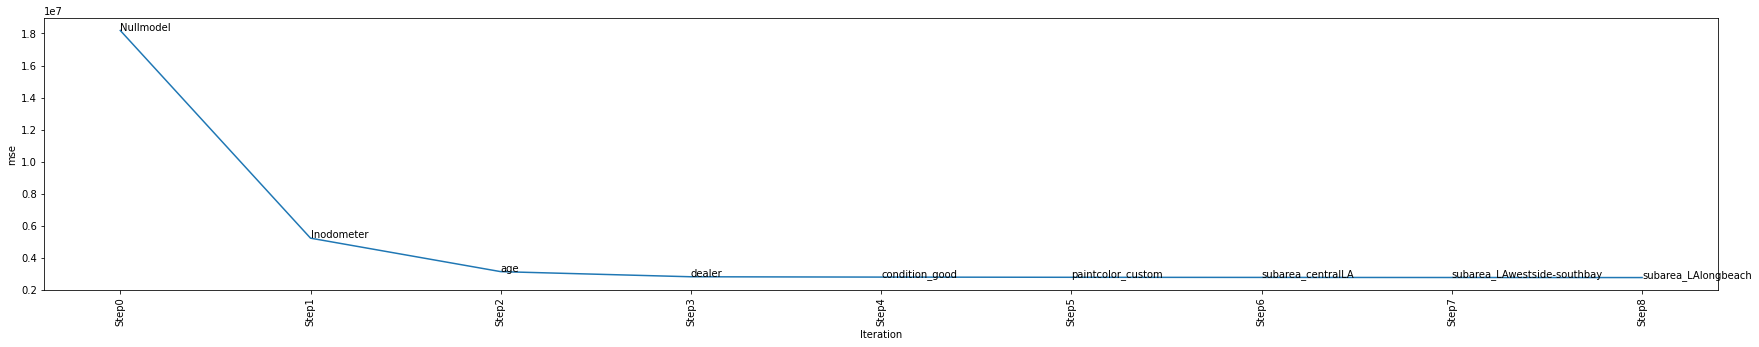

     constant  lnodometer       age  dealer  condition_good  \
438         1   -2.259757 -1.767636       0               0   
406         1    1.004669  0.317154       0               0   
252         1    0.723299  1.185817       0               1   
3           1    0.703762  1.359549       0               0   
132         1   -3.276463 -1.593903       1               0   
..        ...         ...       ...     ...             ...   
24          1    0.277842  0.317154       0               0   
56          1   -0.092823  0.317154       0               0   
63          1    0.789500 -0.377776       0               0   
62          1    0.701324  0.317154       0               1   
416         1   -0.175262 -0.551508       0               1   

     paintcolor_custom  subarea_centralLA  subarea_LAwestside-southbay  \
438                  0                  1                            0   
406                  0                  1                            0   
252                  

In [943]:
curr_x, hist_dict=forward_stepwise_regression_loss(x_train,y_train,"mse",0.157)
print_hist(hist_dict,"mse")
print(curr_x)

In [944]:
#Evaluation:
r2, mse, r2adj, p_liste = get_stats(curr_x,y_train,x_test[curr_x.columns],y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     231.7
Date:                Wed, 23 Feb 2022   Prob (F-statistic):          3.26e-128
Time:                        17:41:44   Log-Likelihood:                -2901.0
No. Observations:                 329   AIC:                             5820.
Df Residuals:                     320   BIC:                             5854.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
constant          

## Lasso regression

In [945]:
x_train = x_train.drop(['constant'],axis=1)
x_test = x_test.drop(['constant'],axis=1)

In [946]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
def LassoRegression(x_train,x_test,y_train,y_test,talpha):
    reg = Lasso(alpha=talpha)
    reg.fit(x_train, y_train)
    print('R squared training set', round(reg.score(x_train, y_train)*100, 2))
    print('R squared test set', round(reg.score(x_test, y_test)*100, 2))
    # Training data
    pred_train = reg.predict(x_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 2))

    # Test data
    pred = reg.predict(x_test)
    r2 = r2_score(y_test,pred)
    N=x_test.shape[0]
    p=x_test.shape[1]
    x = (1-r2)
    y = (N-1) / (N-p-1)
    adj_rsquared = (1 - (x * y))

    mse =mean_squared_error(y_test, pred)
    print("R-squared equals: "+ str(r2))
    print("MSE equals " + str(mse))
    print("adjusted R-squared equals: " + str(adj_rsquared))
    
    #print('MSE test set', round(mse_test, 2))
    return reg

In [947]:
lasso=LassoRegression(x_train,x_test,y_train,y_test,1)

R squared training set 86.12
R squared test set 84.7
MSE training set 2518152.63
R-squared equals: 0.8470357577549769
MSE equals 3078863.0708920383
adjusted R-squared equals: 0.7480588951258442


### checking the development depending on alpha

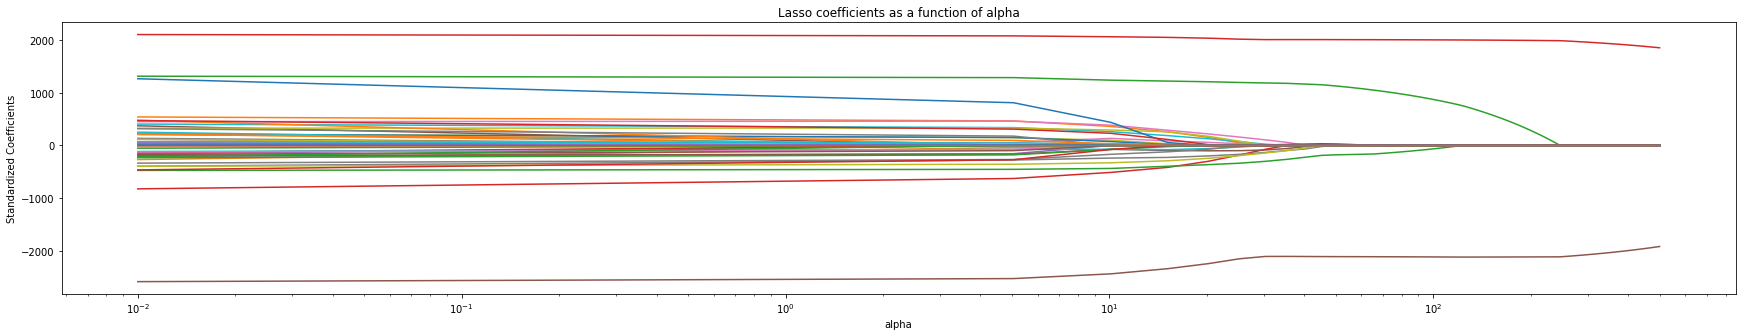

In [948]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');



In [949]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=4, random_state=0, max_iter=10000)

# Fit model
model.fit(x_train, y_train)
alphat=model.alpha_

/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


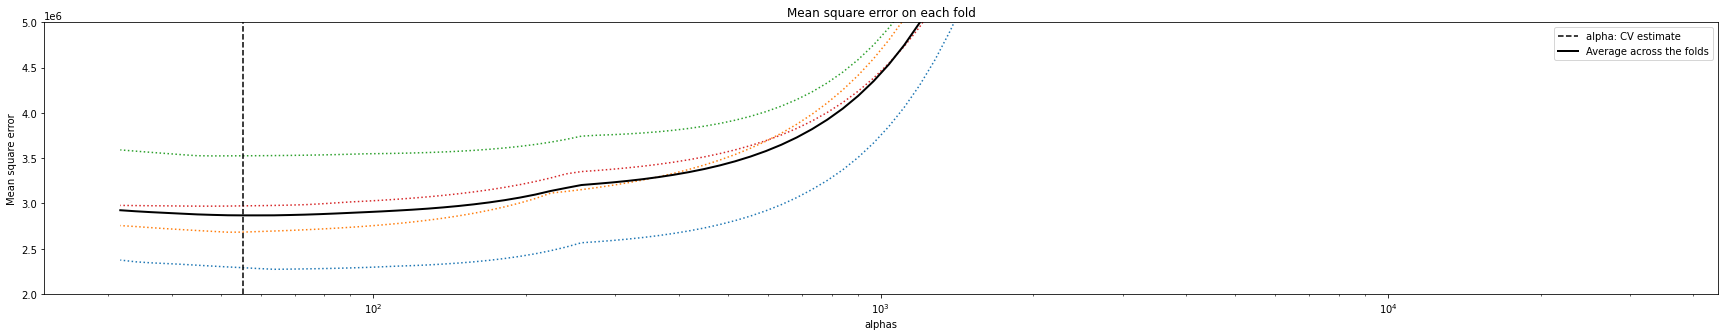

In [950]:
plt.semilogx(model.alphas_, model.mse_path_, ":")

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 2000000, 5000000
plt.ylim(ymin, ymax);

In [951]:
alphat

55.383112097440694

In [952]:
lasso_best = LassoRegression(x_train,x_test,y_train,y_test,alphat)

R squared training set 84.74
R squared test set 84.13
MSE training set 2768862.14
R-squared equals: 0.8413154055936767
MSE equals 3194002.2744302936
adjusted R-squared equals: 0.7386371386248792


#### getting OLS results for these variables

In [1045]:
curr_x = ['dealer', 'year', 'drive_fwd', 'constant']

In [1047]:
r2, mse, r2adj, p_liste = get_stats(x_train[curr_x],y_train,x_test[curr_x],y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     330.2
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           2.64e-98
Time:                        18:12:04   Log-Likelihood:                -2986.2
No. Observations:                 329   AIC:                             5980.
Df Residuals:                     325   BIC:                             5996.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dealer      2066.9580    324.733      6.365      0.0

In [953]:
coefs={}
for entry in list(zip(lasso_best.coef_,x_train.columns)):
    if entry[0] > 0:
        coefs[entry[1]]= entry[0]

In [954]:
coefs

{'dealer': 1100.7151971202059,
 'year': 2005.5326978489736,
 'drive_fwd': 19.102336569447964}

### Best alpha via BIC & aic

In [955]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
X = x_train
y_ = y_train
start_time = time.time()
lasso_lars_ic = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
).fit(X, y_)
fit_time = time.time() - start_time

/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [956]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y_)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [957]:
from sklearn.model_selection import KFold
#k = KFold(n_splits=4, shuffle=False, random_state=None)
def kfold_LASSO(y, data, stat):
    alpha_list = []

    # Calculating OLS for each fold

    #for train_index, test_index in k.split(data):
    for key, val in kfolds.items():
        # print("TRAIN:", train_index, "TEST:", test_index)
        train_index = val['train']
        test_index = val['test']
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lasso_lars_ic = make_pipeline(
        StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
        ).fit(data_train, y_train)
        if stat == "aic":
            alpha_aic = lasso_lars_ic[-1].alpha_
            alpha_list.append(lasso_lars_ic[-1].alpha_)
        
        if stat == "bic":
            lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(data_train, y_train)
            alpha_bic = lasso_lars_ic[-1].alpha_
            alpha_list.append(lasso_lars_ic[-1].alpha_)
        

    return alpha_list

In [958]:
alphas_opt = kfold_LASSO(y_train, x_train, "aic")

/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=1.944e+01, with an active set of 36 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=1.331e+01, with an active set of 39 

In [959]:
import statistics
alphat = statistics.mean(alphas_opt)


In [960]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
3608.801472777418,7482.698846,7482.698846
3525.524479402788,7420.247692,7424.043750
900.0636219254337,5956.225819,5963.817934
248.8626014337212,5831.957966,5843.346140
184.32206224596177,5827.989073,5843.173304
164.86764608121746,5827.953854,5846.934143
156.9721067025354,5829.032327,5851.808673
135.0597322985703,5827.936646,5854.509050
130.76380045621588,5829.381432,5859.749894


In [961]:
alphat = results['AIC criterion'].idxmin()
print("Alpha using AIC: " + str(alphat))
alphat = results['BIC criterion'].idxmin()
print("Alpha using BIC: " + str(alphat))

Alpha using AIC: 135.0597322985703
Alpha using BIC: 184.32206224596177


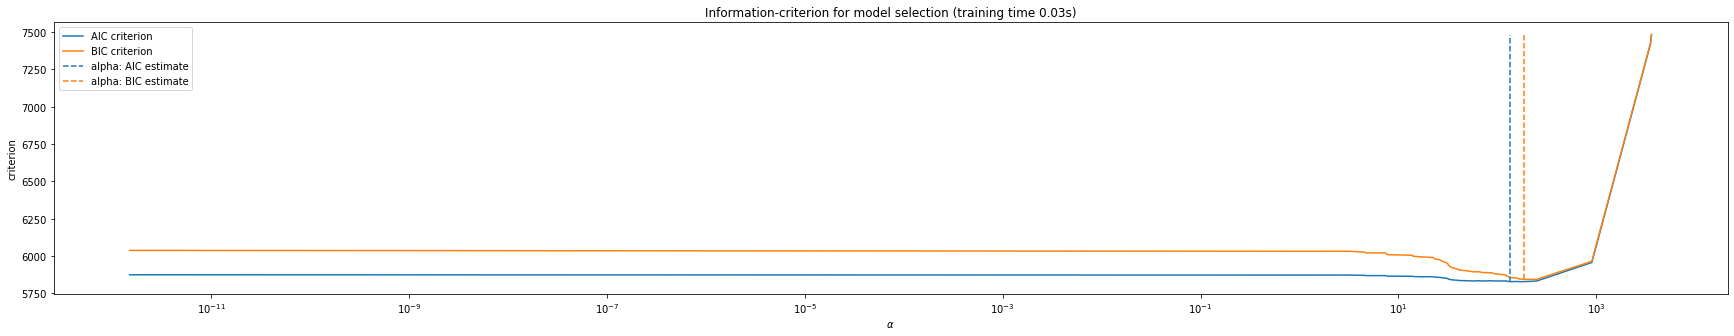

In [962]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

In [963]:
alphat = results['AIC criterion'].idxmin()
lasso_best_aic = LassoRegression(x_train,x_test,y_train,y_test,alphat)

R squared training set 84.1
R squared test set 84.24
MSE training set 2883799.56
R-squared equals: 0.8423707562599333
MSE equals 3172760.1844784846
adjusted R-squared equals: 0.7403753632516549


In [967]:
coefs={}
for entry in list(zip(lasso_best_aic.coef_,x_train.columns)):
    if entry[0] > 0:
        coefs[entry[1]]= entry[0]
coefs

{'dealer': 680.749896676053, 'year': 1998.0409201948776}

#### getting OLS results for these variables

In [1048]:
curr_x = ['dealer', 'year', 'constant']

In [1049]:
r2, mse, r2adj, p_liste = get_stats(x_train[curr_x],y_train,x_test[curr_x],y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     488.4
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           8.40e-99
Time:                        18:15:57   Log-Likelihood:                -2988.3
No. Observations:                 329   AIC:                             5983.
Df Residuals:                     326   BIC:                             5994.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dealer      2271.0935    310.495      7.314      0.0

In [965]:
alphat = results['BIC criterion'].idxmin()
lasso_best_bic = LassoRegression(x_train,x_test,y_train,y_test,alphat)

R squared training set 83.56
R squared test set 84.09
MSE training set 2982159.13
R-squared equals: 0.8408573325660443
MSE equals 3203222.3647458428
adjusted R-squared equals: 0.7378826654028965


In [968]:
coefs={}
for entry in list(zip(lasso_best_bic.coef_,x_train.columns)):
    if entry[0] > 0:
        coefs[entry[1]]= entry[0]
coefs

{'dealer': 379.81933216521895, 'year': 1992.7242669292368}

## Trying the first three variables found by the forward approach 

In [ ]:
curr_x = ['dealer', 'year', 'lnodometer', 'constant']
r2, mse, r2adj, p_liste = get_stats(x_train[curr_x],y_train,x_test[curr_x],y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     601.0
Date:                Sun, 27 Feb 2022   Prob (F-statistic):          3.23e-132
Time:                        22:42:19   Log-Likelihood:                -2907.1
No. Observations:                 329   AIC:                             5822.
Df Residuals:                     325   BIC:                             5837.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dealer      1518.1135    248.515      6.109      0.0

## Implementing the above for the natural logarithmic price

In [970]:
y_test['price'] = np.log(y_test['price'])
y_train['price'] = np.log(y_train['price'])
x_train['constant'] = 1
x_test['constant'] = 1

In [1000]:
x_train['constant'] = 1
x_test['constant'] = 1

# Simple OLS

In [1001]:
from statsmodels.tools.eval_measures import mse,rmse, meanabs
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse,rmse, meanabs

def get_stats(x_train,y_train,x_test,y_test):
    #x_train = sm.add_constant(x_train)
    p_liste=[]
    model = sm.OLS(y_train, x_train)
    results = model.fit()
    print(results.summary())
    for attributeIndex in range (0, len(x_train.columns)):
        p_liste.append(results.pvalues[attributeIndex])
    predictions = results.predict(x_test)
    r2 = r2_score(y_test,predictions)
    mse = mean_squared_error(y_test,predictions)
    #calculate r-squared

    N=x_test.shape[0]
    p=x_test.shape[1]
    x = (1-r2)
    y = (N-1) / (N-p-1)
    adj_rsquared = (1 - (x * y))

    print("R-squared equals: "+ str(r2))
    print("MSE equals " + str(mse))
    print("adjusted R-squared equals: " + str(adj_rsquared))
    
    return r2, mse, adj_rsquared, p_liste

In [1002]:
r2, mse, r2adj, p_liste = get_stats(x_train,y_train,x_test,y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     25.38
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           1.76e-74
Time:                        18:25:21   Log-Likelihood:                -142.65
No. Observations:                 329   AIC:                             373.3
Df Residuals:                     285   BIC:                             540.3
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
index             

# forward stepwise regression

In [1003]:
import matplotlib.pylab as plt

In [1004]:
from pylab import rcParams
def print_hist(hist_dict,stat):

    lists = hist_dict.items() # return a list of tuples
    #You can sort by values using the following, so the graph would look with increaseing gradient
    # lists = sorted(d.items(), key=lambda kv: kv[1], reverse=True)
    x_, y_ = zip(*lists) # unpack a list of pairs into two tuples
    plt.xlabel('Iteration')
    plt.rcParams["figure.figsize"] = (30,5)
    #rcParams['figure.figsize'] = 10, 5
    plt.ylabel(stat)
    y_val=[]
    y_var=[]
    for val in y_:
        y_val.append(val[0])
        y_var.append(val[1])
    plt.plot(x_, y_val)
    plt.xticks(x_,rotation='vertical')
    for i , var in enumerate(y_var):
        plt.text(x_[i],y_val[i],var)
    plt.show()

## STOPPING CRITERION P-VALUES

In [1005]:
from decimal import Decimal, ROUND_HALF_EVEN
#k = KFold(n_splits=4, shuffle=False, random_state=None)
def kfold_stepwise(y, data):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    mse_list=[]
    rsquared_adj = []
    aic_list = []
    bic_list = []
    meanabs_list = []

    # Calculating OLS for each fold

    for key, val in kfolds.items():
        #print(key)
        train_index = val['train']
        test_index = val['test']
        #print(train_index)
        #data_train, data_test = data.iloc[train_index], data.iloc[test_index]
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = sm.OLS(y_train, data_train.astype(float)).fit()
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rsquared_adj += [model.rsquared_adj]
        rmse_list += [rmse(y_train, model.predict())]
        mse_list += [mean_squared_error(y_test,model.predict(data_test))] 
        aic_list += [model.aic]
        bic_list += [model.bic]
        meanabs_list += [meanabs(y_train,model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "mse": mse_list,
        "rsquared_adj": rsquared_adj,
        "aic": aic_list,
        "bic": bic_list,
        "meanabs": meanabs_list
    }

def forward_stepwise_regression_loss(data_ready,y,stat, p_thresh):
    #create dataframe with only constant
    cv_list=[]
    df = data_ready[['constant']].copy()
    i=0
    i=i+1
    #
    #aic = get_mse(df,y)
    cv = kfold_stepwise(y, df)
    cv_list = [cv]
    overview = summarize_cv(cv_list,stat)
    #val = round(overview['Model1']['Average'],2)
    val = overview['Model1']['Average']

    iteration_dict = {'current':val}
    print('Iteration 0 value of null model is ' + str(iteration_dict.get('current')))
    hist_dict ={"Step" + str(0): [iteration_dict.get('current'),"Nullmodel"]}
    curr_model = False
    while curr_model == False:
        for (columnName, columnData) in data_ready.iteritems():
            curr_x = df.copy()
            curr_x[columnName] = columnData.values
            #aic = get_mse(curr_x,y)
            #kfold_stepwise(y, curr_x, k)
            cv = kfold_stepwise(y, curr_x)
            cv_list = [cv]
            overview = summarize_cv(cv_list,stat)
            #val = round(overview['Model1']['Average'],2)
            val = overview['Model1']['Average']
            iteration_dict[columnName] = val
        if stat == "r2" or stat == "rsquared_adj":
            columnToAdd = max(iteration_dict, key=iteration_dict.get)
        if stat == "rmse" or stat == "mse" or stat == "meanabs" or stat == "aic" or stat == "bic":
            columnToAdd = min(iteration_dict, key=iteration_dict.get)
            #check p-values
        print('potential col: ' + columnToAdd)
        pmodel = sm.OLS(y, curr_x)
        presults = pmodel.fit()
        non_significant_var = False
        p_liste = []
        for attributeIndex in range (0, len(curr_x.columns)):
            p_liste.append(presults.pvalues[attributeIndex])
        print(p_liste)
        for v in p_liste:
            #print(Decimal(v).quantize(Decimal('.01'), rounding=ROUND_HALF_EVEN)- Decimal(0.01).quantize(Decimal(p_thresh), rounding=ROUND_HALF_EVEN))
            #if v- p_thresh>0:
            if v > p_thresh:
                non_significant_var = True
                #print(p_liste)
        if columnToAdd == "current":
            curr_model = True
            print('Iteration ' + str(i) + ' current model is the best')
            print(curr_x.columns) 
        else:                                         
            if non_significant_var == True:
                curr_model = True
                print('Iteration ' + str(i) + ' current model is the best')
                print(curr_x.columns)
            else:
                print('Iteration ' + str(i) + ' next column to add is ' + columnToAdd + ' with value ' + str(iteration_dict.get(columnToAdd)))
                hist_dict["Step" + str(i)] =[iteration_dict.get(columnToAdd),columnToAdd]
                df[columnToAdd] = data_ready[columnToAdd].values
                data_ready = data_ready.drop(columnToAdd, axis=1) 
                iteration_dict['current'] = iteration_dict.get(columnToAdd)
                del iteration_dict[columnToAdd]
                i = i+1
    return df,hist_dict

def summarize_cv(cvlist, stat):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0][stat]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

Iteration 0 value of null model is 0.6754097731027965
potential col: age
[0.0]
Iteration 1 next column to add is age with value 0.20070002444498938
potential col: odometer
[0.0, 1.0824244938104493e-88]
Iteration 2 next column to add is odometer with value 0.16313143625920867
potential col: dealer
[0.0, 2.778524215024226e-35, 1.8450185642050267e-16]
Iteration 3 next column to add is dealer with value 0.15596454783480354
potential col: subarea_chicagoN
[0.0, 4.5558022458196304e-35, 9.502101868881427e-14, 0.00011249908710413767]
Iteration 4 next column to add is subarea_chicagoN with value 0.15463209187273924
potential col: subarea_SanFernando
[0.0, 1.511187260133573e-35, 6.187748338741857e-14, 0.00019385072480621464, 0.08742521954825928]
Iteration 5 current model is the best
Index(['constant', 'age', 'odometer', 'dealer', 'subarea_chicagoN'], dtype='object')


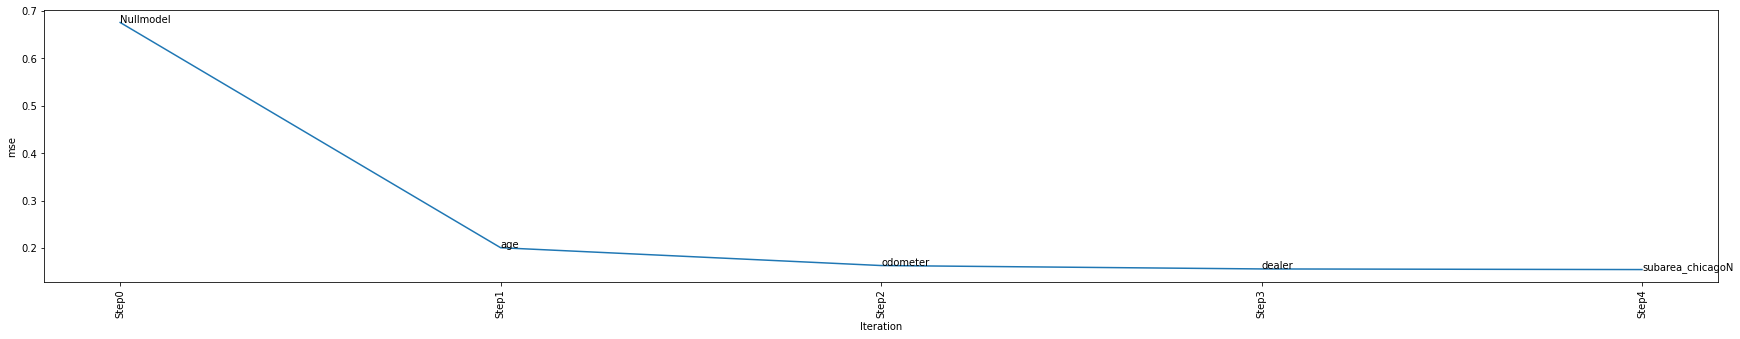

     constant       age  odometer  dealer  subarea_chicagoN
438         1 -1.767636 -1.838999       0                 0
406         1  0.317154  1.412572       0                 0
252         1  1.185817  0.829295       0                 0
3           1  1.359549  0.792289       0                 0
132         1 -1.593903 -2.088036       1                 0
..        ...       ...       ...     ...               ...
24          1  0.317154  0.083278       0                 0
56          1  0.317154 -0.403864       0                 0
63          1 -0.377776  0.957924       0                 0
62          1  0.317154  0.787701       0                 0
416         1 -0.551508 -0.498432       0                 0

[329 rows x 5 columns]


In [1006]:
curr_x, hist_dict=forward_stepwise_regression_loss(x_train,y_train,"mse",0.05)
print_hist(hist_dict,"mse")
print(curr_x)

In [1007]:
#Evaluation:
r2, mse, r2adj, p_liste = get_stats(curr_x,y_train,x_test[curr_x.columns],y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     276.2
Date:                Wed, 23 Feb 2022   Prob (F-statistic):          4.97e-103
Time:                        18:25:32   Log-Likelihood:                -157.58
No. Observations:                 329   AIC:                             325.2
Df Residuals:                     324   BIC:                             344.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
constant             8.3033      0.025  

Iteration 0 value of null model is 0.6754097731027965
potential col: age
[0.0]
Iteration 1 next column to add is age with value 0.20070002444498938
potential col: odometer
[0.0, 1.0824244938104493e-88]
Iteration 2 next column to add is odometer with value 0.16313143625920867
potential col: dealer
[0.0, 2.778524215024226e-35, 1.8450185642050267e-16]
Iteration 3 next column to add is dealer with value 0.15596454783480354
potential col: subarea_chicagoN
[0.0, 4.5558022458196304e-35, 9.502101868881427e-14, 0.00011249908710413767]
Iteration 4 next column to add is subarea_chicagoN with value 0.15463209187273924
potential col: subarea_SanFernando
[0.0, 1.511187260133573e-35, 6.187748338741857e-14, 0.00019385072480621464, 0.08742521954825928]
Iteration 5 next column to add is subarea_SanFernando with value 0.15337683675146108
potential col: paintcolor_white
[0.0, 1.0306118668125915e-35, 1.0177209754477949e-13, 9.092863152321955e-05, 0.0683801274014464, 0.0720721089342671]
Iteration 6 next col

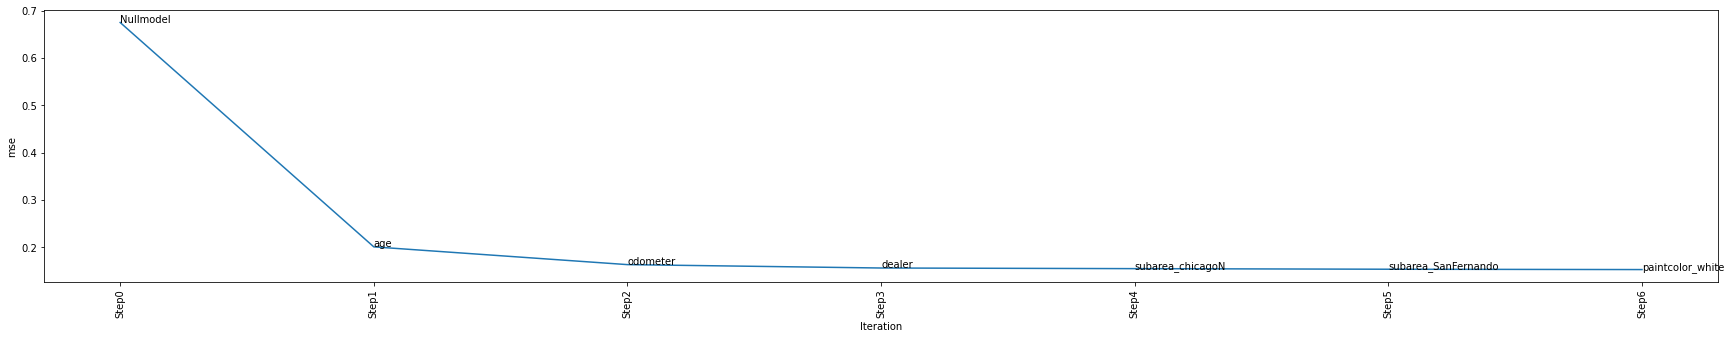

     constant       age  odometer  dealer  subarea_chicagoN  \
438         1 -1.767636 -1.838999       0                 0   
406         1  0.317154  1.412572       0                 0   
252         1  1.185817  0.829295       0                 0   
3           1  1.359549  0.792289       0                 0   
132         1 -1.593903 -2.088036       1                 0   
..        ...       ...       ...     ...               ...   
24          1  0.317154  0.083278       0                 0   
56          1  0.317154 -0.403864       0                 0   
63          1 -0.377776  0.957924       0                 0   
62          1  0.317154  0.787701       0                 0   
416         1 -0.551508 -0.498432       0                 0   

     subarea_SanFernando  paintcolor_white  
438                    0                 0  
406                    0                 0  
252                    0                 1  
3                      0                 0  
132               

In [1008]:
curr_x, hist_dict=forward_stepwise_regression_loss(x_train,y_train,"mse",0.157)
print_hist(hist_dict,"mse")
print(curr_x)

In [1009]:
#Evaluation:
r2, mse, r2adj, p_liste = get_stats(curr_x,y_train,x_test[curr_x.columns],y_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     186.8
Date:                Wed, 23 Feb 2022   Prob (F-statistic):          1.08e-101
Time:                        18:25:45   Log-Likelihood:                -154.97
No. Observations:                 329   AIC:                             323.9
Df Residuals:                     322   BIC:                             350.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
constant                8.2957    

# Lasso regression

LASSO with sklearn

In [1010]:
x_train = x_train.drop(['constant'],axis=1)
x_test = x_test.drop(['constant'],axis=1)

In [1011]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
def LassoRegression(x_train,x_test,y_train,y_test,talpha):
    reg = Lasso(alpha=talpha)
    reg.fit(x_train, y_train)
    print('R squared training set', round(reg.score(x_train, y_train)*100, 2))
    print('R squared test set', round(reg.score(x_test, y_test)*100, 2))
    # Training data
    pred_train = reg.predict(x_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 2))

    # Test data
    pred = reg.predict(x_test)
    r2 = r2_score(y_test,pred)
    N=x_test.shape[0]
    p=x_test.shape[1]
    x = (1-r2)
    y = (N-1) / (N-p-1)
    adj_rsquared = (1 - (x * y))

    mse =mean_squared_error(y_test, pred)
    print("R-squared equals: "+ str(r2))
    print("MSE equals " + str(mse))
    print("adjusted R-squared equals: " + str(adj_rsquared))
    
    #print('MSE test set', round(mse_test, 2))
    return reg

In [1012]:
lasso=LassoRegression(x_train,x_test,y_train,y_test,1)

R squared training set 0.3
R squared test set -3.74
MSE training set 0.67
R-squared equals: -0.037439964530202374
MSE equals 0.6594438430246392
adjusted R-squared equals: -0.7087246474615096


## checking the development depending on alpha

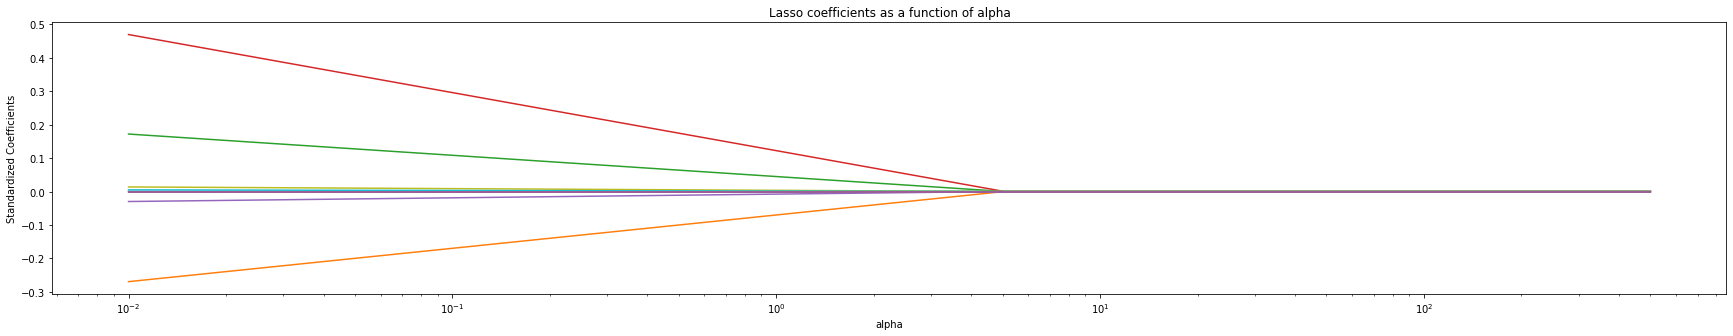

In [1013]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');



In [1014]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=4, random_state=0, max_iter=10000)

# Fit model
model.fit(x_train, y_train)
alphat=model.alpha_

/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


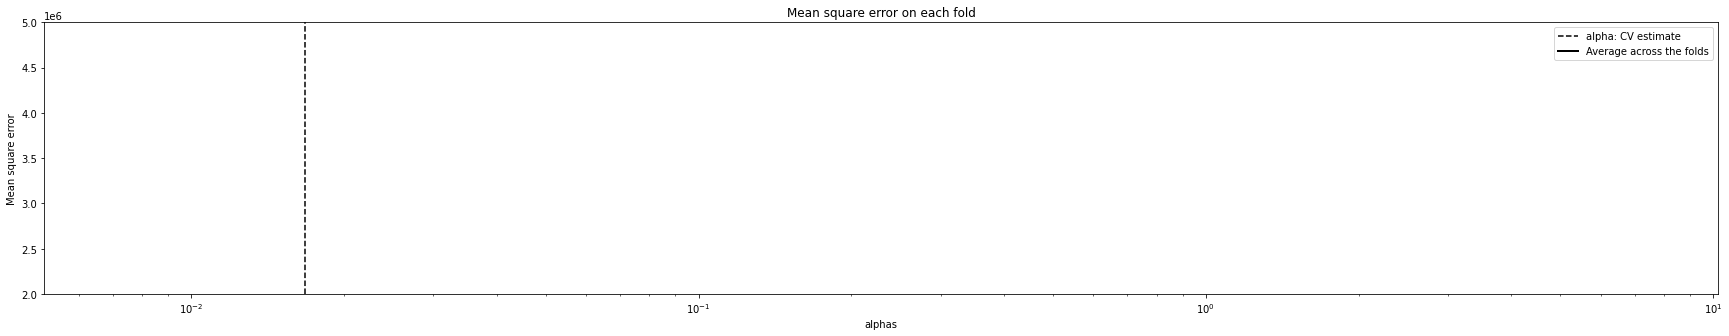

In [1015]:
plt.semilogx(model.alphas_, model.mse_path_, ":")

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 2000000, 5000000
plt.ylim(ymin, ymax);

In [1016]:
alphat

0.016731531821551047

In [1017]:
lasso_best = LassoRegression(x_train,x_test,y_train,y_test,alphat)

R squared training set 76.89
R squared test set 76.16
MSE training set 0.16
R-squared equals: 0.7616229735742217
MSE equals 0.15152323774820695
adjusted R-squared equals: 0.6073790152987182


In [1018]:
coefs={}
for entry in list(zip(lasso_best.coef_,x_train.columns)):
    if entry[0] > 0:
        coefs[entry[1]]= entry[0]

In [1019]:
coefs

{'dealer': 0.12723225294672189,
 'year': 0.4662094665927714,
 'cylinders_4cylinders': 0.006524496729899994}

Best alpha via BIC

In [1020]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
X = x_train
y_ = y_train
start_time = time.time()
lasso_lars_ic = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
).fit(X, y_)
fit_time = time.time() - start_time

/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 54 iterations, alpha=4.286e-05, previous alpha=3.984e-05, with an active set of 45 regressors.
  warnings.warn(


In [1021]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y_)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:682: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 54 iterations, alpha=4.286e-05, previous alpha=3.984e-05, with an active set of 45 regressors.
  warnings.warn(


In [1022]:
from sklearn.model_selection import KFold
#k = KFold(n_splits=4, shuffle=False, random_state=None)
def kfold_LASSO(y, data, stat):
    alpha_list = []

    # Calculating OLS for each fold

    #for train_index, test_index in k.split(data):
    for key, val in kfolds.items():
        # print("TRAIN:", train_index, "TEST:", test_index)
        train_index = val['train']
        test_index = val['test']
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lasso_lars_ic = make_pipeline(
        StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
        ).fit(data_train, y_train)
        if stat == "aic":
            alpha_aic = lasso_lars_ic[-1].alpha_
            alpha_list.append(lasso_lars_ic[-1].alpha_)
        
        if stat == "bic":
            lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(data_train, y_train)
            alpha_bic = lasso_lars_ic[-1].alpha_
            alpha_list.append(lasso_lars_ic[-1].alpha_)
        

    return alpha_list

In [1023]:
alphas_opt = kfold_LASSO(y_train, x_train, "aic")

/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ninawohlert/Development/markant/markant-masterdata/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ninawohlert/Development/markant/markant-masterdata/env/li

In [1024]:
import statistics
alphat = statistics.mean(alphas_opt)


In [1025]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
0.6888182179854963,1336.105034,1336.105034
0.509739304500522,917.628266,921.424324
0.1352824998716316,378.516836,386.108951
0.04353878129447735,331.044615,342.432788
0.03941475935840051,331.422779,346.607010
0.03575493732167996,331.834356,350.814645
0.03546832706101113,333.702875,356.479221
0.03379725644368143,334.719539,361.291944
0.03373866644790319,336.684094,367.052556


In [1026]:
alphat = results['AIC criterion'].idxmin()
print("Alpha using AIC: " + str(alphat))
alphat = results['BIC criterion'].idxmin()
print("Alpha using BIC: " + str(alphat))

Alpha using AIC: 0.04353878129447735
Alpha using BIC: 0.04353878129447735


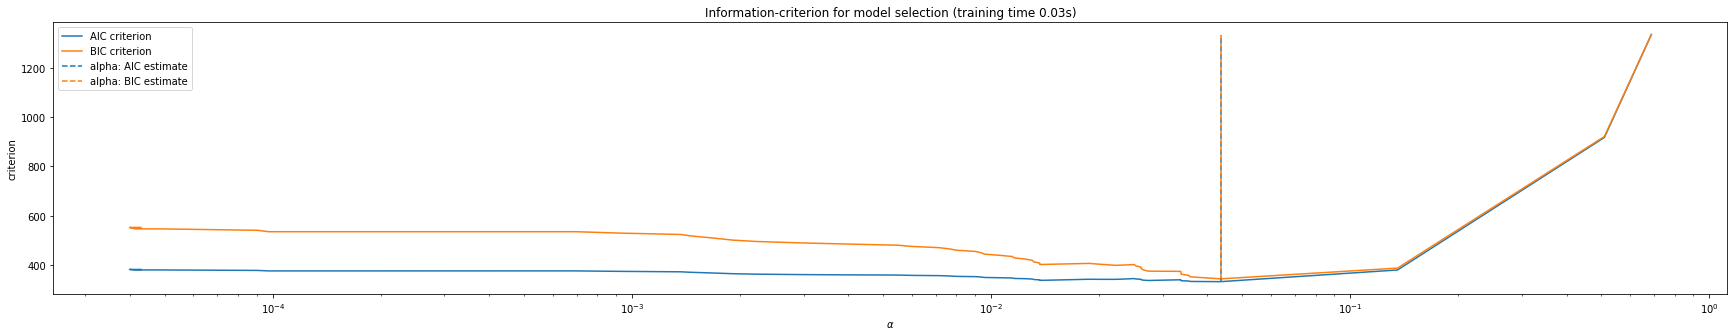

In [1027]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

In [1028]:
alphat = results['AIC criterion'].idxmin()
lasso_best_aic = LassoRegression(x_train,x_test,y_train,y_test,alphat)

R squared training set 75.73
R squared test set 76.25
MSE training set 0.16
R-squared equals: 0.7624954353256785
MSE equals 0.15096866153180563
adjusted R-squared equals: 0.608816011124647


In [1029]:
coefs={}
for entry in list(zip(lasso_best_aic.coef_,x_train.columns)):
    if entry[0] > 0:
        coefs[entry[1]]= entry[0]
coefs

{'year': 0.45783308237635734}

In [1030]:
alphat = results['BIC criterion'].idxmin()
lasso_best_bic = LassoRegression(x_train,x_test,y_train,y_test,alphat)

R squared training set 75.73
R squared test set 76.25
MSE training set 0.16
R-squared equals: 0.7624954353256785
MSE equals 0.15096866153180563
adjusted R-squared equals: 0.608816011124647


In [1031]:
coefs={}
for entry in list(zip(lasso_best_bic.coef_,x_train.columns)):
    if entry[0] > 0:
        coefs[entry[1]]= entry[0]
coefs

{'year': 0.45783308237635734}